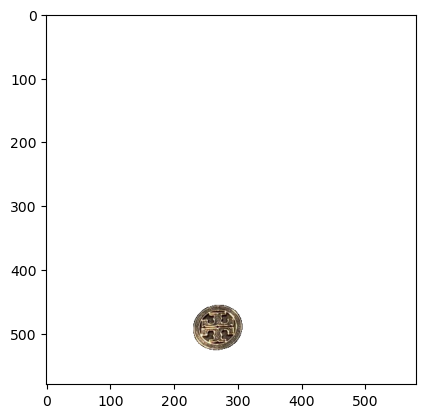

In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def segment_logo(image_path, background_color=(255, 255, 255)):
    # Load the image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Edge detection
    edges = cv2.Canny(blurred, 100, 200)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming largest contour is the logo (This might not always be the case)
    # Sort contours by area and get the largest
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

    # Create an empty mask
    mask = np.zeros_like(gray)

    # Draw the contour on the mask
    cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

    # Create a solid color image for background
    background = np.full_like(img, background_color, dtype=np.uint8)

    # Apply the mask to the original image
    result = np.where(mask[..., None].astype(bool), img, background)

    return result

# This is a placeholder since we need an actual image path.
# Replace 'path_to_handbag_image.jpg' with the actual image path.
segmented_logo = segment_logo('./handbag1.jpg')

# Displaying the result (this will not work in this text-only environment)
# but in a Python environment, you can use:
plt.imshow(cv2.cvtColor(segmented_logo, cv2.COLOR_BGR2RGB))
plt.show()


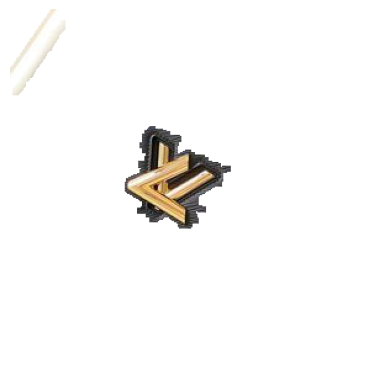

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Re-read the original image
img = cv2.imread("./handbag2.jpeg")

# Convert to grayscale for processing
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Enhance contrast using histogram equalization
equalized = cv2.equalizeHist(gray)

# Edge detection using Canny
edges = cv2.Canny(equalized, 100, 200)

# Dilate the edges to make the contours of the logo more pronounced
kernel = np.ones((5,5), np.uint8)
dilation = cv2.dilate(edges, kernel, iterations=1)

# Find contours
contours, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assuming the logo is one of the prominent contours
# Instead of assuming largest, we can look for a contour with a distinct area or shape
# This threshold can be tuned, and this part of the code might need to be adjusted
# based on the specific characteristics of the logo we're trying to segment
contour_areas = [(i, cv2.contourArea(c)) for i, c in enumerate(contours)]
contour_areas = sorted(contour_areas, key=lambda x: x[1], reverse=True)

# This is a heuristic approach; we assume the logo is not too small or the largest
# Let's assume the logo is within the top 3 largest contours but not the largest
# (as the largest might be the whole bag or a part that is not of interest)
potential_logo_indices = [idx for idx, area in contour_areas[1:3]]

# Create an empty mask
mask = np.zeros_like(gray)

# Draw the potential logo contours on the mask
for i in potential_logo_indices:
    cv2.drawContours(mask, contours, i, (255), thickness=cv2.FILLED)

# Invert the mask so the logo area is black and the rest is white
inverse_mask = cv2.bitwise_not(mask)

# Create a solid color background image
background_color = (255, 255, 255)
background = np.full_like(img, background_color, dtype=np.uint8)

# Apply the inverse mask to the background (to color only non-logo areas)
colored_background = cv2.bitwise_and(background, background, mask=inverse_mask)

# Apply the original mask to the image (to keep only the logo area)
logo = cv2.bitwise_and(img, img, mask=mask)

# Combine the original logo and the new background
segmented_image_with_logo = cv2.add(logo, colored_background)

# Display the image (for visualization in this notebook)
plt.imshow(cv2.cvtColor(segmented_image_with_logo, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide the axis
plt.show()



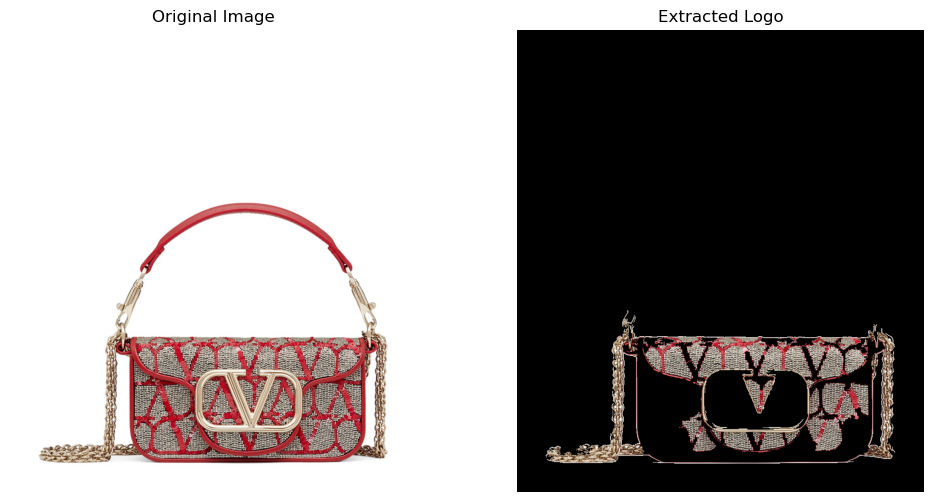

In [10]:
from skimage import io, color, filters, morphology, measure
import matplotlib.pyplot as plt
import numpy as np

# For the sake of example, let's assume we have a sample image loaded
# Since we cannot load external images directly, replace 'sample_image.jpg' with the actual image file path
image_path = './handbag8.jpeg'  # Placeholder for user-provided image path

# Load the image using scikit-image
image = io.imread(image_path)
gray_image = color.rgb2gray(image)

# Enhance edges using the Sobel filter
edges = filters.sobel(gray_image)

# Apply a threshold to get a binary image
threshold_value = filters.threshold_otsu(edges)
binary_mask = edges > threshold_value

# Perform morphological operations to remove small objects and clean up the mask
cleaned_mask = morphology.remove_small_objects(binary_mask, min_size=500)  # min_size can be adjusted
cleaned_mask = morphology.remove_small_holes(cleaned_mask, area_threshold=500)  # area_threshold can be adjusted

# Label the image
labeled_image = measure.label(cleaned_mask)

# Assume the largest object is the logo (this may need to be adjusted)
regions = measure.regionprops(labeled_image)
largest_region = max(regions, key=lambda r: r.area)

# Create a mask for the largest object
logo_mask = np.zeros_like(gray_image, dtype=bool)
for coord in largest_region.coords:
    logo_mask[coord[0], coord[1]] = True

# Apply the mask to the original image to extract the logo
logo = image.copy()
for i in range(3):  # Assuming image has 3 color channels
    logo[:, :, i] = logo[:, :, i] * logo_mask

# Display the original image and the extracted logo side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')

# Extracted logo
ax[1].imshow(logo)
ax[1].set_title('Extracted Logo')
ax[1].axis('off')

plt.show()


0.4049714368872549


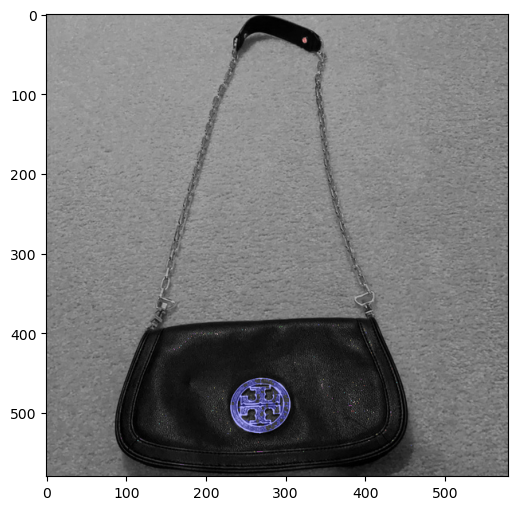

In [11]:
from skimage import io, color
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

# Load your image
image = io.imread('./handbag1.jpg')  # Replace with the path to your image

# If the image is not in grayscale, convert it
gray_image = color.rgb2gray(image) if len(image.shape) == 3 else image

# Rest of your code
thresh = threshold_otsu(gray_image)
print(thresh)
bw = closing(gray_image > thresh, square(3))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)
plt.show()


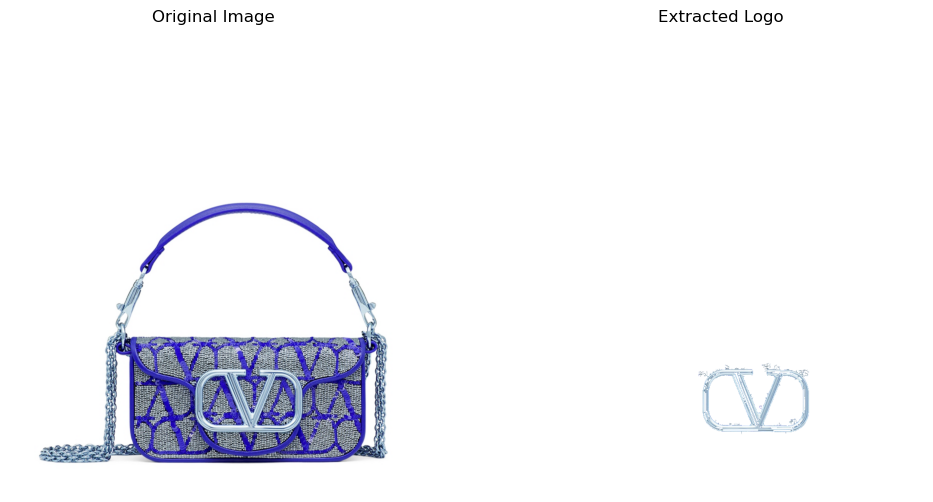

In [17]:
def segment_logo_skimage(image):
    # Apply Otsu's thresholding
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    thresh = threshold_otsu(gray_image)
    bw = closing(gray_image > thresh, square(2))

    # Remove artifacts connected to image border
    cleared = clear_border(bw)

    # Label image regions
    label_image = label(cleared)

    # Create an overlay image with transparent background
    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

    # Find the logo region
    regions = regionprops(label_image)
    logo_region = max(regions, key=lambda r: r.area)  # Assuming the logo is the largest region

    # Create a mask for the logo
    logo_mask = np.zeros_like(gray_image)
    minr, minc, maxr, maxc = logo_region.bbox
    logo_mask[minr:maxr, minc:maxc] = label_image[minr:maxr, minc:maxc] == logo_region.label

    # Extract the logo from the original image
    logo = np.zeros_like(image)
    for i in range(3):  # for each color channel
        logo[:, :, i] = image[:, :, i] * logo_mask

    # Change background to a solid color (e.g., white)
    background_color = [255, 255, 255]  # White background
    for i in range(3):  # for each color channel
        logo[:, :, i][logo_mask == 0] = background_color[i]

    return logo

image = cv2.imread('./handbag8.jpeg')
logo = segment_logo_skimage(image)
# Display the original image and the extracted logo side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')

# Extracted logo
ax[1].imshow(logo)
ax[1].set_title('Extracted Logo')
ax[1].axis('off')

plt.show()

In [3]:
import cv2
import numpy as np

def segment_logo(image):
  """Segments the logo on a handbag.

  Args:
    image: A color image of a handbag.

  Returns:
    An image that contains only the logo on a solid color background.
  """

  # Convert the image to HSV color space.
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  # Define the lower and upper bounds of the logo color.
  # This will need to be adjusted based on the actual color of the logo.
  lower_bound = np.array([0, 0, 100])
  upper_bound = np.array([10, 255, 255])

  # Create a mask based on the color threshold.
  mask = cv2.inRange(hsv, lower_bound, upper_bound)

  # Apply the mask to the image to segment the logo.
  logo = cv2.bitwise_and(image, image, mask=mask)

  # Change the background of the image to solid color.
  background = np.ones(image.shape, dtype=np.uint8) * 255
  logo = cv2.bitwise_or(logo, background, mask=np.bitwise_not(mask))

  return logo


# Load the input image.
image = cv2.imread("handbag1.jpg")

# Segment the logo on the handbag.
logo = segment_logo(image)

# Save the output image.
cv2.imwrite("logo.jpg", logo)


True

# Machine Learning

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Define data directories and paths
train_data_dir = "path/to/train/images"
train_mask_dir = "path/to/train/masks"
val_data_dir = "path/to/validation/images"
val_mask_dir = "path/to/validation/masks"

# Define image dimensions and number of channels
img_height = 256
img_width = 256
num_channels = 3

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1. / 255)

# Generate data batches for training and validation
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode="binary",
    mask_dir=train_mask_dir
)
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=16,
    class_mode="binary",
    mask_dir=val_mask_dir
)

# Define U-Net model
inputs = Input(shape=(img_height, img_width, num_channels))

# Encoder path
down1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
down1 = Conv2D(64, (3, 3), activation='relu', padding='same')(down1)
pool1 = MaxPooling2D((2, 2))(down1)

down2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
down2 = Conv2D(128, (3, 3), activation='relu', padding='same')(down2)
pool2 = MaxPooling2D((2, 2))(down2)

down3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
down3 = Conv2D(256, (3, 3), activation='relu', padding='same')(down3)
pool3 = MaxPooling2D((2, 2))(down3)

down4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
down4 = Conv2D(512, (3, 3), activation='relu', padding='same')(down4)

# Decoder path
up1 = UpSampling2D((2, 2))(down4)
up1 = Concatenate()([up1, down3])
up1 = Conv2D(256, (3, 3), activation='relu', padding='same')(up1)
up1 = Conv2D(256, (3, 3), activation='relu', padding='same')(up1)

up2 = UpSampling2D((2, 2))(up1)
up2 = Concatenate()([up2, down2])
up2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
up2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)

up3 = UpSampling2D((2, 2))(up2)
up3 = Concatenate()([up3, down1])
up3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
up3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(up3)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

# Save the trained model
model.save("trained_unet_model.h5")

# Load and use the trained model for logo segmentation on new images
def segment_logo(image):
    # Preprocess the image
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (img_height, img_width))
    image = np.expand_dims(image, axis=0)

    # Predict the mask
    mask = model.predict(image)[0]

    # Threshold and post-process the mask
    mask = (mask > 0.5).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=np.ones((3, 3), np.uint8))

    # Segment the logo and combine with background
    logo = image[0] * mask
    background = np.ones_like(logo) * 255
    segmented_logo = cv2.bitwise_or(logo, background)

    return segmented_logo

# Example usage
segmented_logo = segment_logo("path/to/new_image.jpg")
cv2.imwrite("segmented_logo.jpg", segmented_logo)

